In [51]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [52]:
from pprint import pprint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
#------------------
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

import spacy
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [53]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

### Uploading data

In [127]:
popular=pd.read_csv('../Data/Most_popular_id_2019_2021.csv')
articles=pd.read_csv('../Data/articles_data.csv') #add full_text columns which contains text for each article
articles=articles[articles.has_full_text==1]
articles.tail()

,id,link,headline_main,abstract,snippet,lead_paragraph,print_section,print_page,source,pub_date,...,news_desk,section_name,type_of_material,nyt_id,word_count,uri,byline_original,byline_organization,had_duplicates,has_full_text
13680,14123,https://www.nytimes.com/2020/06/25/opinion/sun...,The Black-White Wage Gap Is as Big as It Was i...,Recent research indicates little progress sinc...,Recent research indicates little progress sinc...,That’s remarkable. Despite decades of politica...,SR,11,The New York Times,2020-06-25T09:00:31+0000,...,OpEd,Opinion,Op-Ed,nyt://article/6e1b4aa2-a1e9-5bf4-ae0b-b2cd7879...,908.0,nyt://article/6e1b4aa2-a1e9-5bf4-ae0b-b2cd7879...,By David Leonhardt,NaN,0,1
13681,14124,https://www.nytimes.com/2020/09/24/opinion/sun...,"How Did a Young, Unknown Lawyer Change the World?",Ruth Bader Ginsburg took on the obstacles to w...,Ruth Bader Ginsburg took on the obstacles to w...,I’ve been asked repeatedly in recent days to e...,SR,9,The New York Times,2020-09-24T12:49:01+0000,...,OpEd,Opinion,Op-Ed,nyt://article/e181a773-a50b-5731-9b4b-0eb7375b...,1135.0,nyt://article/e181a773-a50b-5731-9b4b-0eb7375b...,By Linda Greenhouse,NaN,0,1
13682,14125,https://www.nytimes.com/article/trump-pardons....,Can Trump Pre-emptively Pardon Allies or Himse...,The president has discussed potential pardons ...,The president has discussed potential pardons ...,WASHINGTON — As President Trump enters the end...,A,20,The New York Times,2020-12-02T18:49:28+0000,...,Washington,U.S.,News,nyt://article/a1a0f026-4724-5957-833c-0a500956...,1353.0,nyt://article/a1a0f026-4724-5957-833c-0a500956...,By Charlie Savage,NaN,0,1
13685,14128,https://www.nytimes.com/2020/04/24/realestate/...,The Easier Way to Make a Garden Bed,It might seem like the lazy gardener’s approac...,It might seem like the lazy gardener’s approac...,I’ve tried various methods of making a garden ...,RE,4,The New York Times,2020-04-24T13:00:08+0000,...,RealEstate,Real Estate,News,nyt://article/2020167b-f6bb-5759-ac61-b19951a1...,1135.0,nyt://article/2020167b-f6bb-5759-ac61-b19951a1...,By Margaret Roach,NaN,0,1
13686,14129,https://www.nytimes.com/2021/02/21/science/fau...,Fauci expects Americans could still need to we...,President Biden’s chief medical adviser for Co...,President Biden’s chief medical adviser for Co...,"Dr. Anthony S. Fauci, President Biden’s chief ...",NaN,NaN,The New York Times,2021-02-21T16:58:02+0000,...,Science,Science,News,nyt://article/69ee1b45-13f6-53c3-beb3-8b8d3f97...,516.0,nyt://article/69ee1b45-13f6-53c3-beb3-8b8d3f97...,By Abby Goodnough,NaN,0,1


# LDA

#### NOTE: We do not provide texts of articles for copyright reasons but you need full text for each article to run LDA model. Table above includes urls for each article (and nyt_id if you are familiar with NYT API). Please add the column "full_text" to the article's data if you intend to run a model.  You can also just load our model further in this notebook. 

In [278]:
# text=pd.read_csv('../Data/articles_text.csv')
# articles=pd.merge(articles, text[['id', 'full_text']], how='left', on='id', validate='one_to_one')
# articles.shape

#### Preparing data

In [123]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [124]:
data = articles.full_text.str.lower().values.tolist()
data_words = list(sent_to_words(data))

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
bigram = gensim.models.Phrases(data_words, min_count=15, threshold=1000)
trigram = gensim.models.Phrases(bigram[data_words], threshold=1000)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#------
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams = make_trigrams(data_words_bigrams)
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#Dictionary
dictionary = corpora.Dictionary(data_lemmatized)
dictionary.filter_extremes(no_below=15, no_above=0.5)

# Create Corpus
texts = data_lemmatized
corpus = [dictionary.doc2bow(text) for text in texts]

len(dictionary)

20668

#### Preview of the data

In [129]:
for i in range(5):
    print('Initial beginning:',data[i][:100])
    print('Processed (first 20):', texts[i][:20], '\n')

Initial beginning: in the recent rush of proposals to tax the rich, democrats have forgotten — or never really cared to
Processed (first 20): ['recent', 'rush', 'proposal', 'tax', 'rich', 'democrat', 'forget', 'never', 'really', 'care', 'learn', 'important', 'lesson', 'country', 'successful', 'reduce', 'poverty', 'inequality', 'do', 'tax'] 

Initial beginning: the sackler family would give up ownership of purdue pharma, the company blamed for much of the opio
Processed (first 20): ['sackler', 'family', 'give', 'ownership', 'company', 'blame', 'much', 'opioid', 'epidemic', 'pay', 'money', 'term', 'settlement', 'proposal', 'resolve', 'thousand', 'federal', 'state', 'lawsuit', 'accord'] 

Initial beginning: “the scream” is fading. and tiny samples of paint from the 1910 version of edvard munch’s famous ima
Processed (first 20): ['scream', 'fade', 'tiny', 'sample', 'paint', 'version', 'edvard_munch', 'famous', 'image', 'angst', 'ray', 'laser', 'beam', 'even', 'high', 'power', 'scientist', 

## Model

#### Run model (parameters from grid search): 

In [67]:
# lda_model = gensim.models.LdaMulticore(corpus, num_topics=40, id2word=dictionary, chunksize=64, passes=50, 
#                                          per_word_topics=True, offset=1, decay=0.5, eval_every=16) 

#### Or just load model:

In [130]:
lda_model = gensim.models.ldamodel.LdaModel.load("../Data/Model/LDA_final_40_topics")

#### Calculate coherence

In [72]:
coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherencemodel.get_coherence()

0.6011043075694673

#### Visualization

In [131]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.094502 -0.155848       1        1  0.763431
1      0.198652 -0.049650       2        1  3.953580
2     -0.018201 -0.081911       3        1  1.684916
3      0.228346  0.037278       4        1  1.984679
4     -0.087254 -0.049855       5        1  2.788071
5     -0.151522 -0.011274       6        1  2.867064
6      0.084113  0.076373       7        1  6.134989
7      0.116742 -0.102083       8        1  2.864241
8      0.104769  0.081099       9        1  1.091148
9     -0.164728  0.057233      10        1  2.340283
10    -0.124291 -0.058327      11        1  2.993439
11     0.108974 -0.102367      12        1  3.966006
12     0.046219  0.034483      13        1  1.386661
13     0.012936  0.025909      14        1  3.146433
14     0.020064  0.118853      15        1  2.608534
15    -0.041133  0.163471      16        1  5.213909
16     0.115471 -0.149277      17        1  0.311088
17     0.042190 -0.078938      18        1  1.231491
18    -0.226191 -0.000081      19        1  1.834441
19    -0.080649 -0.112289      20        1  2.849095
20     0.074361 -0.226345      21        1  0.199190
21    -0.013952 -0.012616      22        1  6.127682
22     0.142395  0.021353      23        1  2.877741
23     0.012616  0.148803      24        1  1.393296
24    -0.096479  0.003421      25        1  1.437469
25    -0.004347  0.068863      26        1  2.368903
26    -0.133778 -0.013361      27        1  1.808910
27    -0.050227  0.091300      28        1  2.475598
28     0.158311 -0.040900      29        1  6.517257
29    -0.070810 -0.163561      30        1  0.698405
30    -0.177424  0.014687      31        1  2.856327
31     0.089670  0.168414      32        1  1.074836
32    -0.164494 -0.082503      33        1  2.906213
33     0.123698 -0.066709      34        1  0.440986
34     0.054716  0.154865      35        1  3.076345
35    -0.129794  0.147221      36        1  1.631724
36    -0.004146  0.162847      37        1  4.128384
37    -0.023491 -0.112309      38        1  2.447362
38     0.102614  0.027976      39        1  1.138399
39     0.020556  0.065757      40        1  2.381476, topic_info=           Term          Freq         Total Category  logprob  loglift
2210      trump  47749.000000  47749.000000  Default  30.0000  30.0000
1996         ms  30003.000000  30003.000000  Default  29.0000  29.0000
729   president  32857.000000  32857.000000  Default  28.0000  28.0000
972      school  20918.000000  20918.000000  Default  27.0000  27.0000
341     company  17620.000000  17620.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
485       share   1096.348051   6484.336778  Topic40  -5.2155   1.9600
435        news   1117.700975   9845.834104  Topic40  -5.1962   1.5617
80        email    958.039289   7352.759991  Topic40  -5.3503   1.6995
2065    service    932.068955   7880.998088  Topic40  -5.3778   1.6026
270      system    900.044549  10290.240495  Topic40  -5.4127   1.3009

[3015 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
16642      5  0.977223    abdication
3809      34  0.985047           abe
6005      38  0.990254  abolitionist
6235       5  0.027309      abortion
6235      10  0.008032      abortion
...      ...       ...           ...
13815      2  0.026148           zoo
13815     17  0.938057           zoo
13815     25  0.032685           zoo
16533     40  0.991449    zuckerberg
17063     23  0.989551        zurich

[15605 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40])

## Summary tables

In [133]:
id_seq = articles.id.values.tolist()

def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()

    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break

    # Add original text and id to the end of the output
    contents = pd.Series(data)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    id_seq_series = pd.Series(id_seq)
    sent_topics_df = pd.concat([sent_topics_df, id_seq_series], axis=1)
    
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text', 'Article_id']
    return(sent_topics_df)

def make_summary_table_for_topics(df_topic_sents_keywords, texts):
    
    sent_topics_sorteddf_mallet = pd.DataFrame()

    for i, grp in df_topic_sents_keywords.groupby('Dominant_Topic'):
        sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                                 grp.sort_values(['Perc_Contribution'], ascending=[False]).head(1)], 
                                                axis=0) 
    sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text", 'Best_Article_id']

    topic_freq = (doc_topic_dists.drop(columns=['id']).T* doc_lengths).T.sum()#(doc_topic_dists.T * doc_lengths).T.sum()
    topic_proportion = (topic_freq / topic_freq.sum()).reset_index()
    topic_proportion.columns = ['Topic_Num', 'Relevance']
    
    topic_proportion['Topic_Num']=topic_proportion['Topic_Num'].astype(float)
    
    result=pd.merge(topic_proportion, sent_topics_sorteddf_mallet, on='Topic_Num').reset_index(drop=True)
    result.sort_values(by=['Relevance'], ascending=False, inplace=True, ignore_index=True)
    return result

def get_doc_topic(corpus, model):
    doc_topic = list() 
    for doc in corpus:
        doc_topic.append([x[1] for x in lda_model.__getitem__(doc, eps=0)[0]])
    return doc_topic

In [135]:
#Dominant topic for each document
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts)
doc_topic_dists=pd.DataFrame(get_doc_topic(corpus, lda_model))
doc_topic_dists.insert(0, 'id', df_topic_sents_keywords['Article_id'])
#Most frequent topics (Relevance)
doc_lengths=np.array([len(x) for x in corpus])
summary_table=make_summary_table_for_topics(df_topic_sents_keywords, texts)
#summary_table.to_csv('../Data/Model/LDA_final_40_topics_summary_table.csv', index=False)
#summary_table=pd.read_csv('../Data/Model/LDA_final_40_topics_summary_table.csv')
summary_table.head(10)

,Topic_Num,Relevance,Topic_Perc_Contrib,Keywords,Text,Best_Article_id
0,28.0,0.066875,0.7944,"family, home, friend, feel, child, old, mother...","newly paraplegic at the age of 23, i needed an...",118
1,21.0,0.066435,0.6866,"political, america, article, editor, hear, com...",for the last few months i’ve been one of the t...,945
2,6.0,0.059287,0.8137,"really, feel, lot, mean, kind, talk, start, ha...","unlike topics like math or science, social ski...",1751
3,15.0,0.049172,0.8026,"virus, coronavirus, health, test, case, pandem...",the united states’ leading authority on infect...,11948
4,11.0,0.042964,0.6227,"book, write, story, world, read, writer, man, ...","\n harold bloom, the prodigious literary crit...",5005
5,1.0,0.042161,0.7146,"open, place, street, room, city, old, design, ...",there’s nothing like a pretty homemade card to...,13646
6,36.0,0.040233,0.8771,"pay, money, percent, tax, economic, job, worke...",washington — the economic relief plan that is ...,10542
7,13.0,0.030943,0.5936,"city, york, county, home, resident, local, com...",[this article is no longer being updated. up-t...,6039
8,7.0,0.030842,0.7775,"music, play, film, movie, song, star, watch, c...",the 63rd annual grammy awards were held in los...,13167
9,34.0,0.030103,0.9169,"study, dr, researcher, research, percent, univ...",being overweight is linked to an increased ris...,1526


## Main Text: Table 1

In [212]:
topic_num_name=pd.read_csv('../Data/LDA_final_topic_names.csv', index_col=0)[['New_long']].rename(columns={'New_long': 'Topic'})

final_table=summary_table.copy()
final_table['Text']=final_table['Text'].str[:100]
final_table['Topic_Num']=final_table['Topic_Num'].astype(int)+1
final_table['Relevance']=np.round(final_table['Relevance'],3)

final_table['Topic']=topic_num_name.loc[final_table.Topic_Num.tolist(), :].Topic.tolist()
final_table=final_table.iloc[:, [0,6,1,3,5]]

final_table=pd.merge(final_table, articles.iloc[:,:3], left_on='Best_Article_id', right_on='id')
final_table['Example']=final_table.headline_main+'\n'+final_table.link
final_table.set_index('Topic_Num', inplace=True)
final_table=final_table.iloc[:, [0,1,2,6]]

topic_name=final_table.iloc[:,:1]
final_table.Keywords=final_table.Keywords.str.title()

# with pd.option_context("max_colwidth", 1000):
#     print(final_table.to_latex(caption='Topics', label='all_topics', index_names=False, longtable=True))
order=final_table.index
final_table.index=list(range(1,41))
final_table.head(10)

,Topic,Relevance,Keywords,headline_main
1,Family,0.067,"Family, Home, Friend, Feel, Child, Old, Mother...",Tiny Love Stories: ‘We Were Never Going to Ven...
2,Politics,0.066,"Political, America, Article, Editor, Hear, Com...",The Two Crises of Conservatism
3,Emotions and Feelings,0.059,"Really, Feel, Lot, Mean, Kind, Talk, Start, Ha...","An Adult’s Guide to Social Skills, for Those W..."
4,Coronavirus Pandemic,0.049,"Virus, Coronavirus, Health, Test, Case, Pandem...","U.S. Surpasses 150,000 Coronavirus Deaths, Far..."
5,Books,0.043,"Book, Write, Story, World, Read, Writer, Man, ...","Harold Bloom, Critic Who Championed Western Ca..."
6,Architecture,0.042,"Open, Place, Street, Room, City, Old, Design, ...","Make a Card, Any Card"
7,"Money, Personal Finance",0.040,"Pay, Money, Percent, Tax, Economic, Job, Worke...",New Stimulus Package Brings Big Benefits to th...
8,New York City,0.031,"City, York, County, Home, Resident, Local, Com...",Driving and Travel Restrictions Across the Uni...
9,Music/Movies,0.031,"Music, Play, Film, Movie, Song, Star, Watch, C...",2021 Grammys Winners: The Full List
10,"Health Research, Lifestyle Advice",0.030,"Study, Dr, Researcher, Research, Percent, Univ...",Where You Carry Body Fat May Affect How Long Y...


### Export to latex

In [145]:
# final_table.index=list(range(1,41))
# with pd.option_context("max_colwidth", 1000):
#     print(final_table.iloc[:,:3].to_latex(caption='Topics', label='all_topics', index_names=False, longtable=True))

## Table A3

In [195]:
df_examples=pd.DataFrame(columns=['example_1', 'example_2','example_3','prev_1','prev_2','prev_3'])

for topic_num in range(40):

    top3=doc_topic_dists.sort_values(by=topic_num, ascending=False).iloc[:3,:].loc[:, ['id',topic_num]]
    top3=pd.merge(top3, articles, how='left', on='id').iloc[:,:4].rename(columns={topic_num: 'prev'})
    top3['example']='\href{'+top3.link+'}{'+top3.headline_main+'}'
    top3=top3.drop(columns=['link', 'headline_main'])#.rename(columns={'id': 'columns'})
    top3['id']=['1', '2', '3']
    top3=top3.melt(id_vars=['id'])
    top3['id']=top3.variable+'_'+top3['id']
    df_examples=df_examples.append(pd.pivot_table(top3, values='value', columns=['id'], aggfunc=np.sum), ignore_index=True)
    
df_examples=pd.merge(topic_num_name, df_examples, right_on=df_examples.index+1, left_on='Topic_Num')
df_examples.index=df_examples.index+1

df_examples.iloc[:5,[1,2,3,4]]

,Topic,example_1,example_2,example_3
1,Israel,\href{https://www.nytimes.com/2019/08/20/opini...,\href{https://www.nytimes.com/2021/05/17/opini...,\href{https://www.nytimes.com/2020/01/29/opini...
2,Architecture,\href{https://www.nytimes.com/2021/02/06/at-ho...,\href{https://www.nytimes.com/2019/05/09/trave...,\href{https://www.nytimes.com/2019/05/06/t-mag...
3,World News,\href{https://www.nytimes.com/2020/01/10/opini...,\href{https://www.nytimes.com/2019/11/08/world...,\href{https://www.nytimes.com/2020/06/22/world...
4,Food,\href{https://www.nytimes.com/2020/04/20/dinin...,\href{https://www.nytimes.com/2020/06/26/dinin...,\href{https://www.nytimes.com/2019/11/15/dinin...
5,Joe Biden,\href{https://www.nytimes.com/2020/02/14/us/po...,\href{https://www.nytimes.com/2020/03/01/us/po...,\href{https://www.nytimes.com/2020/02/22/us/po...


In [16]:
# with pd.option_context("max_colwidth", 1000):
#     print(df_examples.iloc[:,[1,2,3,4]].to_latex(caption='Examples', label='topic_examples', index_names=False, longtable=True, escape=False))

## Figure A6

In [258]:
topic_name=pd.read_csv('../Data/LDA_final_topic_names.csv', index_col=0).loc[order, :][['New_short']].rename(
    columns={'New_short': 'Topic'})

topic_num_name=topic_name.Topic.to_list()

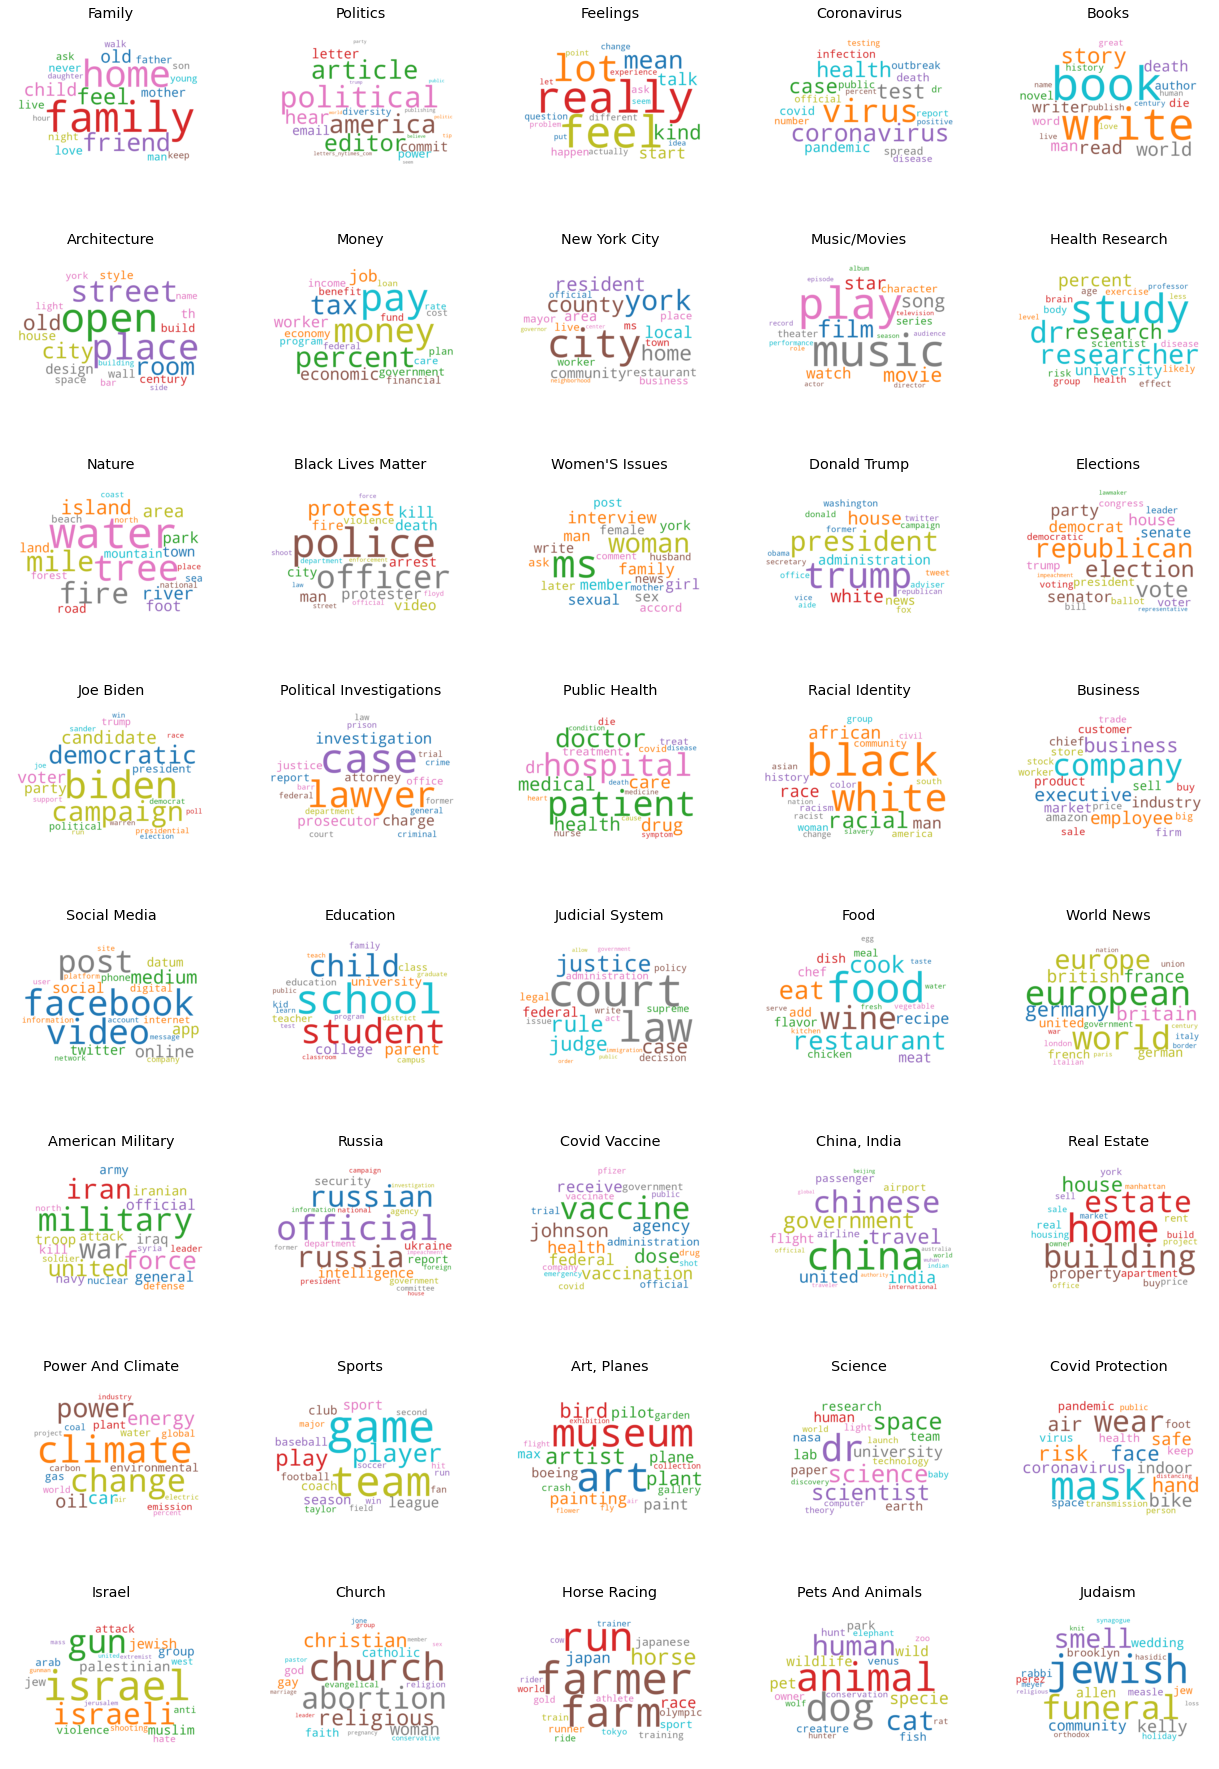

In [259]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

mask = np.array(Image.open("cloud.png"))
topic_nums=summary_table.Topic_Num.astype(int).tolist()
# titles=["relationships", 'political article', 'feelings', 'pandemic', 'books', 'outdoors', 'money', 'location', 'music and movies', 
#         'study','area','police', 'female','Trump','election']

topics=topic_num_name
titles=[' '.join([y.title() for y in x.split('_')]) for x in topics]
clouds=lda_model.show_topics(num_topics=40, num_words = 20, formatted = False)

def print_clouds(clouds, topic_nums, titles=None, nrows=3, ncols=3, figsize=(18, 18)):
    fig, axs = plt.subplots(figsize=figsize,nrows=nrows, ncols=ncols)

    for i in range(nrows*ncols):
        cloud=clouds[topic_nums[i]][1]
        wordcloud = WordCloud(max_words=30, background_color="white", prefer_horizontal=1, 
                              mask=mask, colormap=plt.get_cmap('tab10')).generate_from_frequencies(dict(cloud))
        axs[i//ncols,i%ncols].imshow(wordcloud, interpolation='bilinear')
        axs[i//ncols,i%ncols].axis("off")
        if titles is None:
            axs[i//ncols,i%ncols].set_title('topic '+str(topic_nums[i]+1))
        else:
            #axs[i//ncols,i%ncols].set_title('topic '+str(topic_nums[i]+1)+ ' : ' + titles[i])
            axs[i//ncols,i%ncols].set_title(titles[i])
            
print_clouds(clouds, topic_nums, titles, nrows=8, ncols=5, figsize=(18*1.2, 25*1.3))

#### examples

In [260]:
def print_examples(summary_table):
    for i in range(5):
        num, freq, doc = summary_table.loc[i,:][[0,1,4]]
        print('topic:', num, ' freq:', np.round(freq, 2), '\n')
        #print(lda_model.print_topic(int(num)), '\n')
        print("Example:", doc[:200], '\n\n')
        
print_examples(summary_table)

topic: 28.0  freq: 0.07 

Example: newly paraplegic at the age of 23, i needed answers. where to live, how to live, why to live? one afternoon a colleague (and secret crush) visited me at the rehabilitation center. he took me on my fir 


topic: 21.0  freq: 0.07 

Example: for the last few months i’ve been one of the teachers for a yale course entitled “the crisis of liberalism,” about recent challenges to the liberal order from populists and progressives, socialists an 


topic: 6.0  freq: 0.06 

Example: unlike topics like math or science, social skills are more of a “learn on the job” kind of skill. when you’re a child, you can learn how to manage conflict, make friends and navigate groups by doing i 


topic: 15.0  freq: 0.05 

Example: the united states’ leading authority on infectious disease expressed hope in april that no more than 60,000 people in the country would die from the coronavirus. a revered research center predicted a  


topic: 11.0  freq: 0.04 

Example:  
 harold 

## Main Text: Figure 2

In [262]:
id_seq = articles.id.values.tolist()
id_seq_series = pd.Series(id_seq)
doc_lengths=pd.Series(np.array([len(x) for x in corpus]))
df_doc_lengths=pd.concat([doc_lengths, id_seq_series], axis=1)
df_doc_lengths.columns = ['Length','value']

month_article=pd.melt(popular.copy().drop(columns=['rank', 'id_viewed']),  id_vars=['date']).drop(columns=['variable'])
month_article.date=month_article.date.str[:7] 

In [263]:
df_prev=pd.DataFrame()

grouped = month_article.groupby('date')

for name, group in grouped:
    group=pd.merge(group, df_doc_lengths, how='left', on='value')
    group=pd.merge(group, doc_topic_dists, how='left', left_on='value', right_on='id')
    group_topics=group.iloc[:, 4:]
    group_lengths=np.array(group.iloc[:, 2])
    topic_freq = (group_topics.T* group_lengths).T.sum()
    topic_proportion = (topic_freq / topic_freq.sum()).reset_index()
    topic_proportion.columns = ['Topic_Num', 'Relevance']
    topic_proportion=topic_proportion[['Relevance']].T
    topic_proportion.index=[name]
    df_prev=df_prev.append(topic_proportion)
month_x_top_10=df_prev[summary_table.Topic_Num.astype(int).tolist()[:10]]
month_x_top_10.index.name='date'

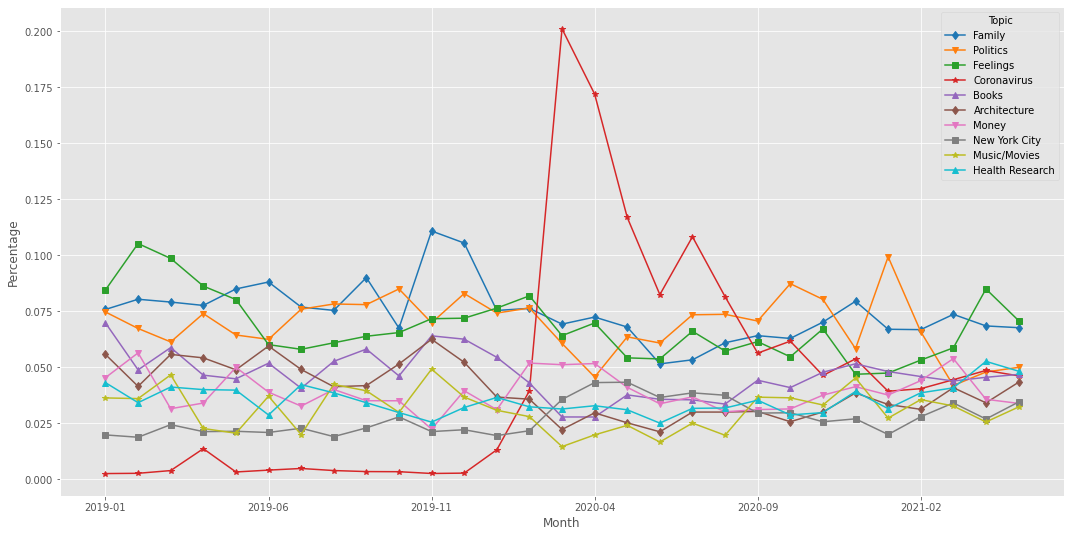

In [266]:
plt.figure(figsize=(18, 9))
markers = ["d", "v", "s", "*", "^", "d", "v", "s", "*", "^"]
ax=month_x_top_10.plot(ax=plt.axes(), colormap='tab10')

for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])

n=[int(x) + 1 for x in month_x_top_10.columns]
plt.legend(topic_name.loc[n,'Topic'].to_list(), loc='best', title='Topic')
plt.xlabel('Month')
plt.ylabel('Percentage')
#plt.title('Average Topic Prevalence per Month')
plt.show()